In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

In [43]:
def plot_lines(df, x, y):
    plt.plot(df[x], df[y])
    plt.title('Daily Total Female Births in California')
    plt.xlabel('Date')
    plt.ylabel('Number of births')
    plt.show()

In [83]:
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv")

In [6]:
display(df.head())
display(df.info())
display(df.describe())

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


None

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [84]:
# Check Stationary
def print_stationary(result):
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"
    print(stationarity_interpretation)

result = adfuller(df["meantemp"])
print_stationary(result)

if result[1] > 0.05:  
    df["meantemp_diff"] = df["meantemp"].diff()#.dropna().to_frame().reset_index(drop=True)
    df = df[~df["meantemp_diff"].isna()]
    result = adfuller(df["meantemp_diff"])
    print("\n-------------")
    print_stationary(result)

ADF Statistic: -2.0210690559206728
p-value: 0.27741213723016056
Non-Stationary

-------------
ADF Statistic: -16.378720267074705
p-value: 2.764863137594486e-29
Stationary


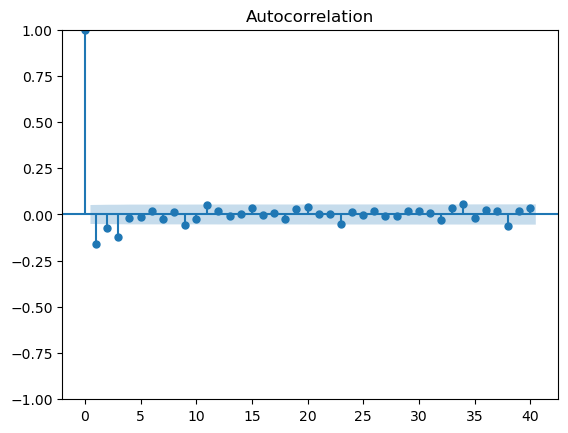

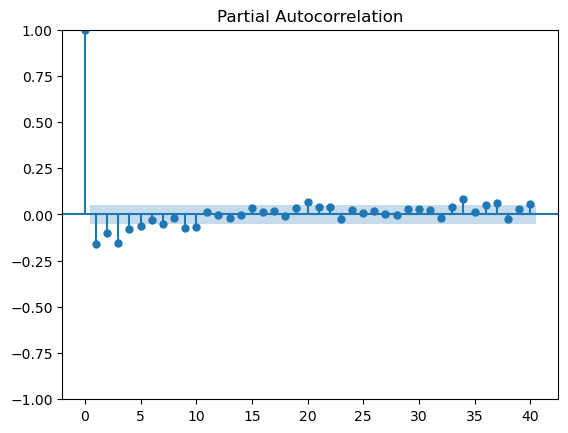

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

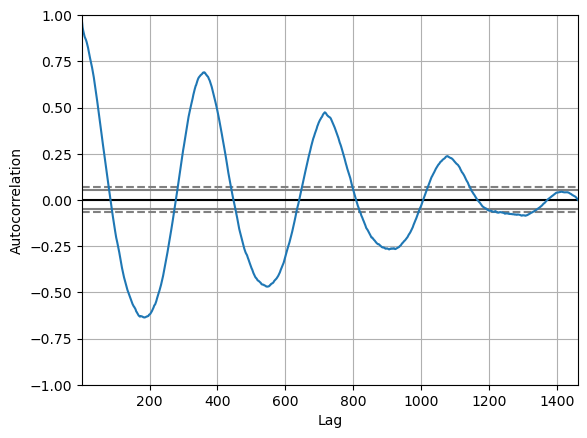

In [82]:
plot_acf(df["meantemp_diff"], lags=40)
plot_pacf(df["meantemp_diff"], lags=40)
plt.show()
autocorrelation_plot(df["meantemp"])
# plt.show()

In [55]:
df.columns

Index(['meantemp'], dtype='object')

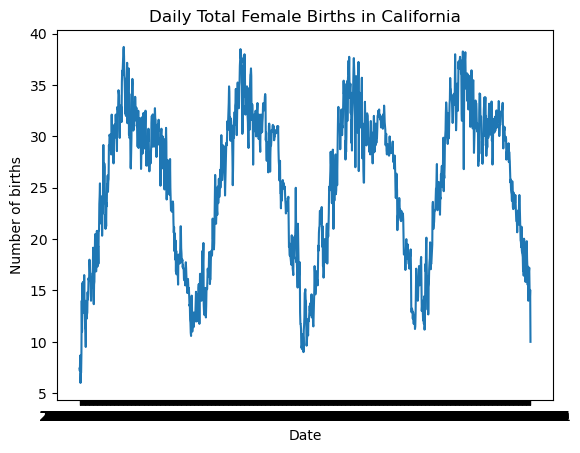

In [78]:
plot_lines(df, "date", "meantemp")

### How to Choose Values of p, d and q? 
- p is the number of autoregressive terms,
- d is the number of nonseasonal differences,
- q is the number of lagged forecast errors in the prediction equation.

There are various ways to choose the values of parameters of the ARIMA model. Without being confused we can do this using the following steps:

1. Test for stationarity using the augmented dickey fuller test.
2. If the time series is stationary try to fit the ARMA model, and if the time series is non-stationary then seek the value of `d`. 
3. If the data is getting stationary then draw the autocorrelation and partial autocorrelation graph of the data.
4. Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of `p` because the cut-off point to the PACF is `p`. 
5. Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of `q` because the cut-off point to the ACF is `q`.     

In [88]:
df_copy = df.copy()
df_copy.head()

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_diff
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,-2.600000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,-0.233333
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1.500000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,-2.666667
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000,1.000000


In [90]:
df_copy.set_index("date", inplace=True)
df_copy.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_diff
date,,,,,
2013-01-02,7.400000,92.000000,2.980000,1017.800000,-2.600000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,-0.233333
2013-01-04,8.666667,71.333333,1.233333,1017.166667,1.500000
2013-01-05,6.000000,86.833333,3.700000,1016.500000,-2.666667
2013-01-06,7.000000,82.800000,1.480000,1018.000000,1.000000


<Axes: xlabel='date'>

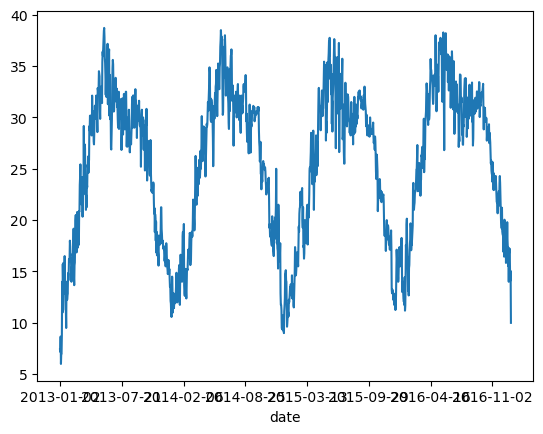

In [91]:
df_copy["meantemp"].plot()

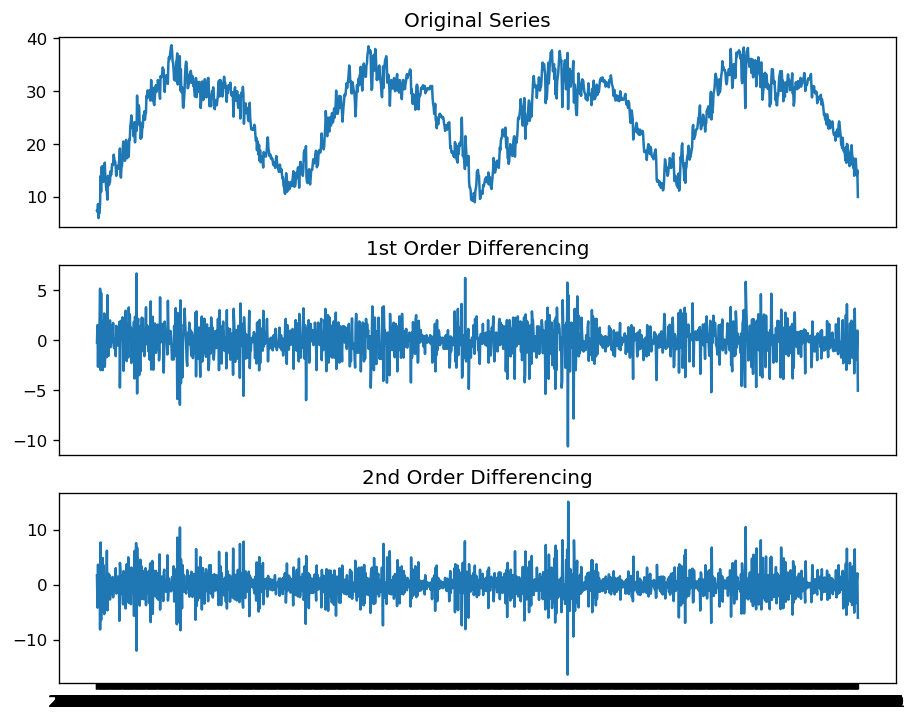

In [92]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_copy.meantemp); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_copy.meantemp.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_copy.meantemp.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

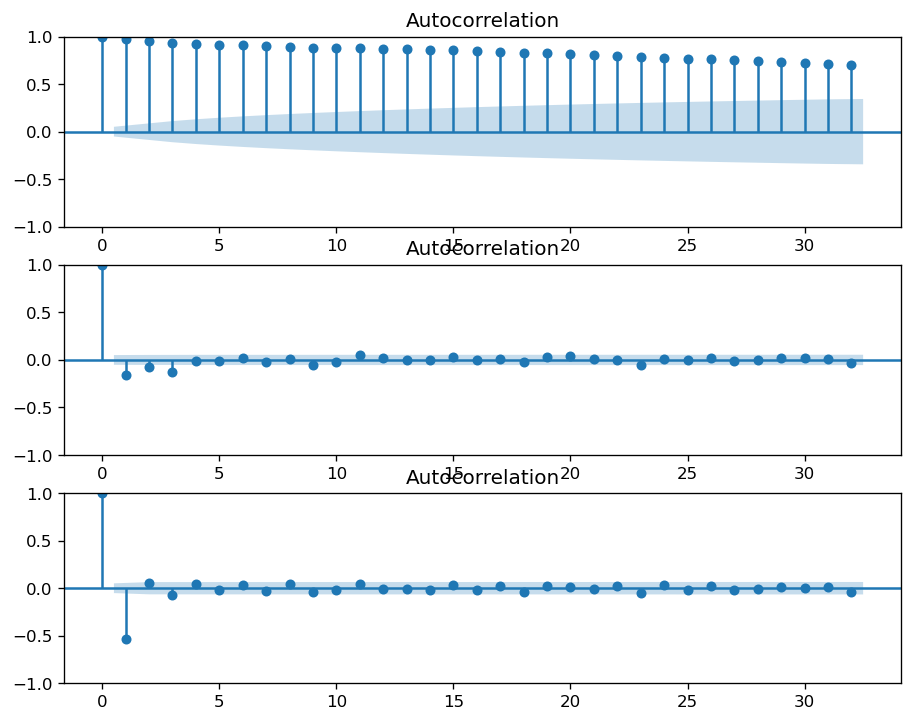

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_copy.meantemp, ax=ax1)
plot_acf(df_copy.meantemp.diff().dropna(), ax=ax2)
plot_acf(df_copy.meantemp.diff().diff().dropna(), ax=ax3)
print()

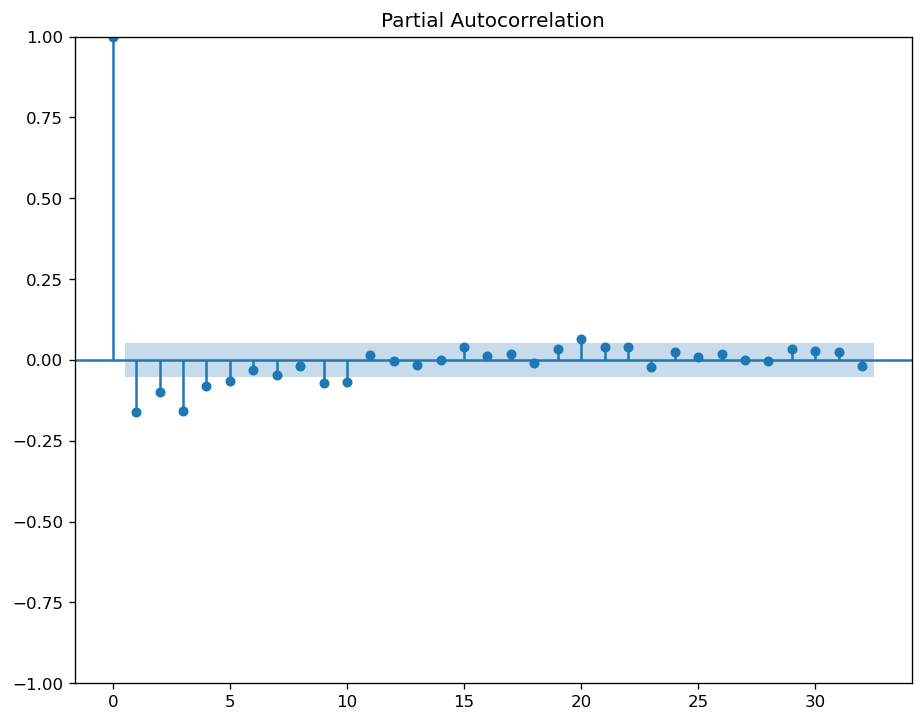

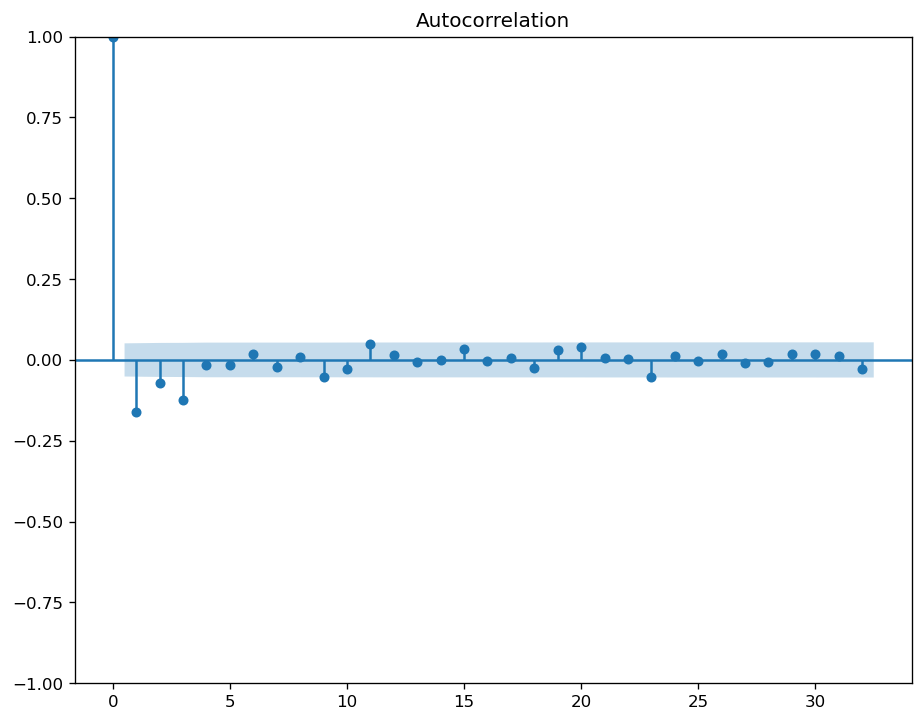

In [96]:
plot_pacf(df_copy.meantemp.diff().dropna())
plot_acf(df_copy.meantemp.diff().dropna())
print()

In [117]:
df_copy["meantemp_diff"].head()

date
2013-01-02   -2.600000
2013-01-03   -0.233333
2013-01-04    1.500000
2013-01-05   -2.666667
2013-01-06    1.000000
Name: meantemp_diff, dtype: float64

In [118]:
p, d, q = 4, 1, 3
model = ARIMA(df_copy["meantemp"], order=(p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

c:\Users\gansh\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gansh\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gansh\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\gansh\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gansh\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\state

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1461
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2762.321
Date:                Mon, 14 Oct 2024   AIC                           5540.642
Time:                        00:35:57   BIC                           5582.932
Sample:                    01-02-2013   HQIC                          5556.418
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2756      3.477     -0.079      0.937      -7.091       6.540
ar.L2          0.3310      0.209      1.585      0.113      -0.078       0.740
ar.L3         -0.0248      1.029     -0.024      0.981      -2.042       1.992
ar.L4         -0.0291      0.260     -0.112      0.911      -0.538       0.480
ma.L1          0.0553      3.478      0.016      0.987      -6.762       6.872
ma.L2         -0.5086      0.817     -0.622      0.534      -2.110       1.093
ma.L3         -0.0747      1.437     -0.052      0.959      -2.891       2.742
sigma2         2.5756      0.074     34.952      0.000       2.431       2.720
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               269.77
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

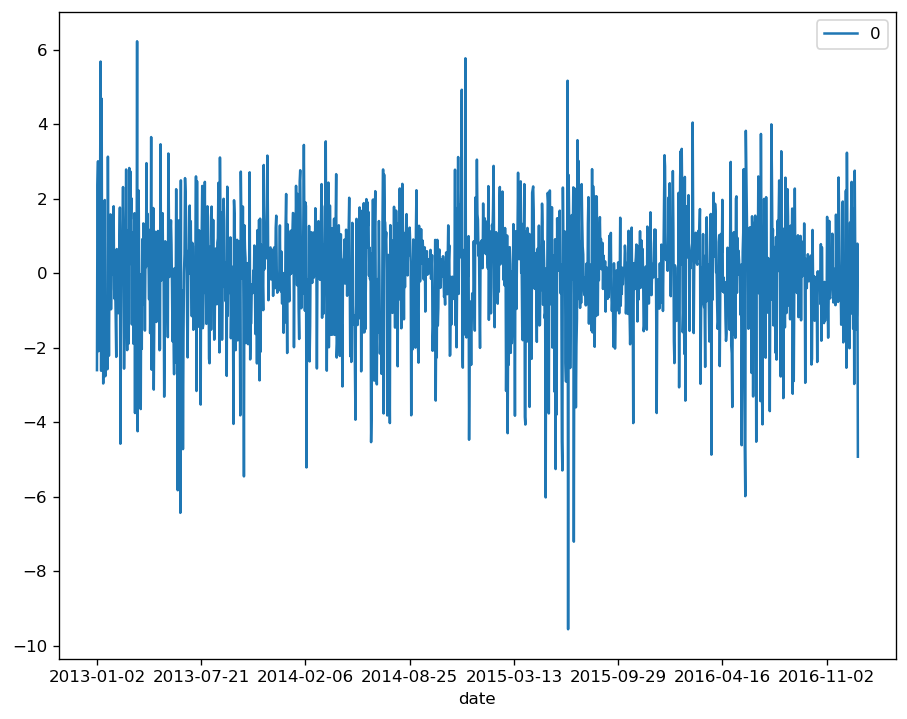

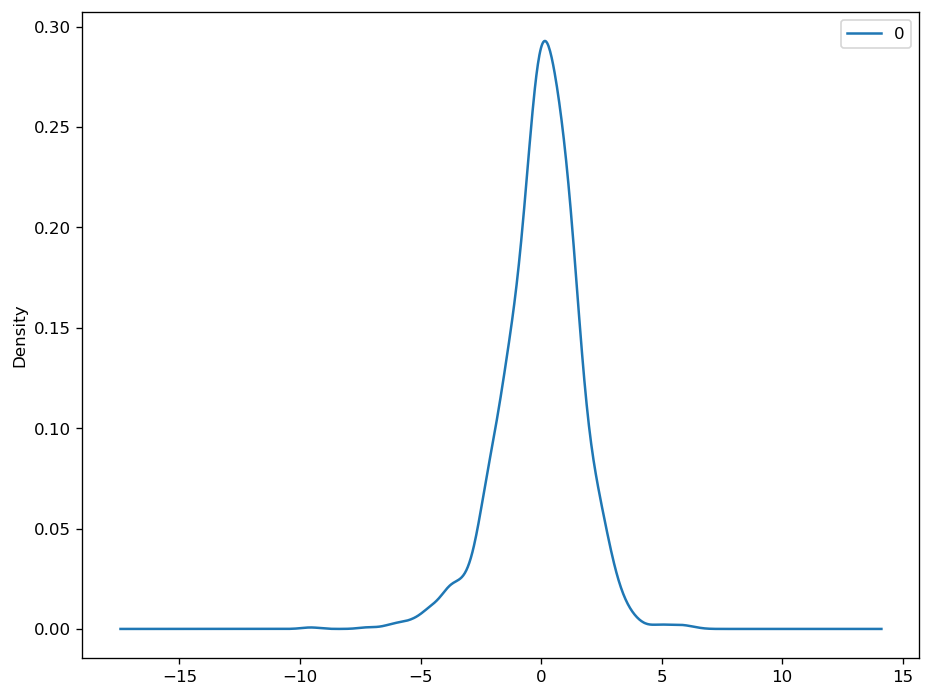

                 0
count  1461.000000
mean     -0.016826
std       1.602207
min      -9.554090
25%      -0.862625
50%       0.089596
75%       0.974235
max       6.226503


In [108]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [109]:
output = model_fit.forecast()

In [110]:
len(output)

1

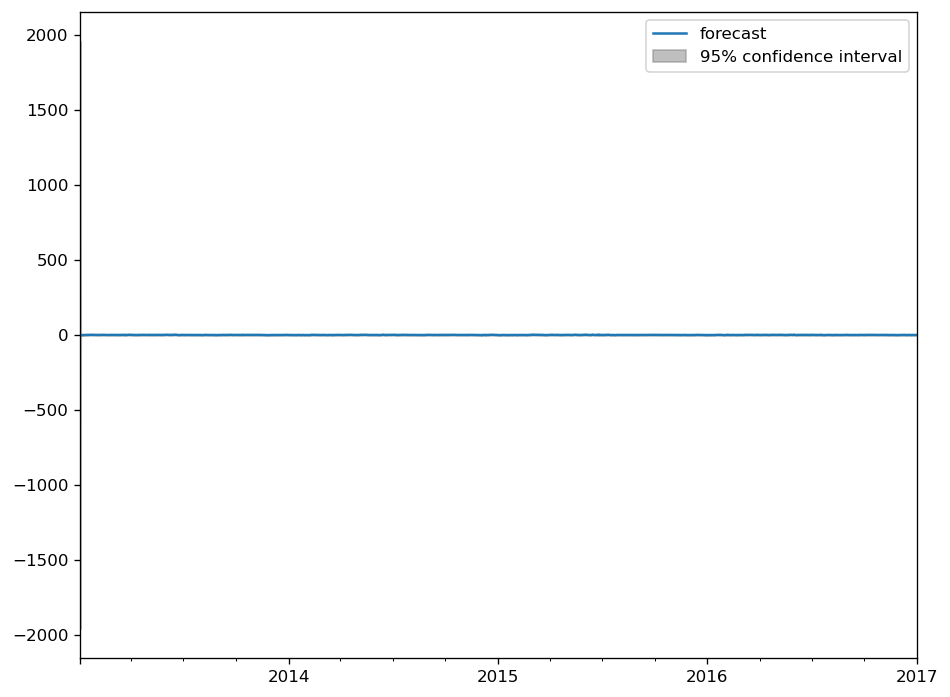

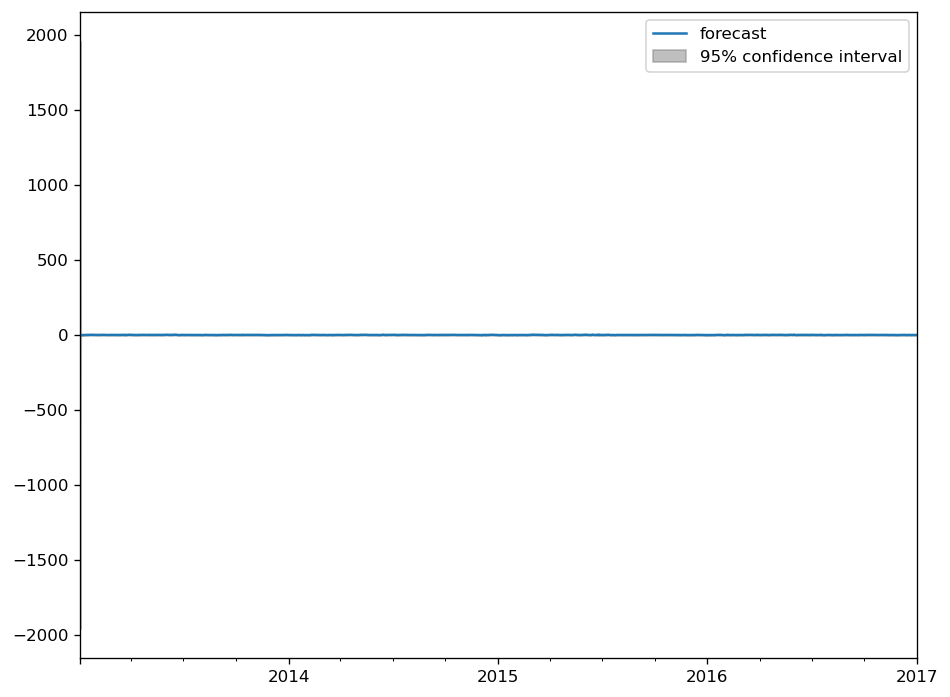

In [115]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit)

In [19]:
import datetime
from decimal import *

def to_nanoseconds(datetime_str):
    dt = datetime.datetime.fromisoformat(datetime_str.replace('Z', '+00:00'))
    print(dt)
    ts = dt.timestamp()
    print(ts)
    return Decimal(f'{ts:.9f}')

In [32]:
x = datetime.datetime(2020, 5, 17, 13, 11, 12, 123456789)

ValueError: microsecond must be in 0..999999

In [34]:
import time
time.time()
time.time_ns()

1729157154514161600

In [47]:
def format_my_nanos(nanos):
    dt = datetime.datetime.fromtimestamp(nanos / 1e9)
    print(dt)
    print(nanos % 1e3)
    return '{}{:03.0f}'.format(dt.strftime('%Y-%m-%dT%H:%M:%S.%f'), nanos % 1e3)

In [49]:
1722863472123456789 %1000

789

In [48]:
dt = format_my_nanos(1722863472123456789)
print(dt)

2024-08-05 21:11:12.123457
768.0
2024-08-05T21:11:12.123457768


In [26]:
to_nanoseconds("2024-08-05T13:11:12.123456789+00:00")

ValueError: Invalid isoformat string: '2024-08-05T13:11:12.123456789+00:00'

In [37]:
dt = datetime.datetime.fromtimestamp(1722863472.123456789)
print(dt)

2024-08-05 21:11:12.123457


In [42]:

to_nanoseconds("2024-08-05T21:11:12.123457Z")

2024-08-05 21:11:12.123457+00:00
1722892272.123457


Decimal('1722892272.123456955')

In [10]:
to_nanoseconds("2024-08-05T00:00:00+00:00")

2024-08-05 00:00:00+00:00
1722816000.0


Decimal('1722816000.000000000')